# Valorant Project: Interactive Dashboard  


<hr>  
  
### Interactive Dashboard Outline:  

Be able to identify the overall meta of agents on each map based on player ranks  
* Be able to filter through by ranks first; should be within a one rank group difference
> _example_: A player in Gold 1 will most likely queue with and against a team ranging from Silver 1 to Plat 1; there will be an average rank in a team and each member will be within one rank group deviation from the average; the two teams fighting agianst each other should have an average difference of one rank (Gold 1 vs Gold 2)  
  
* Then be able to filter through maps, since agents performs differently on maps  

* From there display the agent's pick rate and win rate  
> some agents may have low pick rates and high win rates meaning a niche pick that players may not be able to play against or it's only effective in certain situations (maps)  
> popular and winning agents are the prevailing meta  
> popular but non winning agents may mean that it's just a pick for fun or the playerbase only knows that person and applies the agent for bad situations (bad comp/bad map)
> low win rate and low pick rate means that it is out of meta and not that viable    
  
* Maybe an additional feature on the performance of the agent given a set team comp based on classes  
> Different popular permutations available to select; win rate and pick rate given that there is already a just a flash duelist the rest is ambigous or a flash duelist, dome controller, sentinel, info initiator




##### Design:  

* Ranks filter can be a range slider, setting the range of ranks to consider (can be as close as 1 rank group difference [gold and plats] or up to 3 [bronze, silver, gold, plat]); defaults should be 2 since it does happen but usually only 1 or 2 whose rank is 2 groups away from the highest; so maybe 1.5 is more accurate  
* Dropdown for the maps  
* Checkboxes for teammates that have already locked in  
* A button to confirm that all selections have been made; in case loading in the graphs take awhile (avoids loading graph until the user is done inputting all necessary info)

<hr>  
  
## Code

### Load in Data

In [6]:
import pandas as pd
import numpy as np
import pickle as pkl




runs = []

with open("C:\\Users\\Binaryxx Sune\\Documents\\Programming\\personal_projects\\data\\competitive_data.pkl", "rb") as comp_data_file:
    try:
        while True:
                runs.append(pkl.load(comp_data_file))
    except:
        pass



matches = sum(runs, [])
agent = []
val_map = []
rank = []
outcome = []



for match in matches:
        # get map played by each player
        for i in range(10):
            val_map.append(match["metadata"]["map"])

        # get agent selected by each player and their rank
        for player in match["players"]["all_players"]:
            agent.append(player["character"])
            rank.append(player["currenttier"])

        # get match outcome of each player
        for player in match["players"]["all_players"]:
            player_team = player["team"].lower()
            outcome.append(match["teams"][player_team]["has_won"])



data_dict = {"agent": agent, "val_map" : val_map, "rank": rank, "win": outcome}

val_data = pd.DataFrame(data_dict)



val_data

,agent,val_map,rank,win
0,Reyna,Haven,14,True
1,Phoenix,Haven,14,True
2,Fade,Haven,13,True
3,Killjoy,Haven,12,False
4,Jett,Haven,15,False
...,...,...,...,...
2695,Harbor,Pearl,5,True
2696,Viper,Pearl,7,False
2697,Reyna,Pearl,0,False
2698,Reyna,Pearl,17,True


### Create the Necessary Features  
  
* Ranks  
> Rank Labels  
> Remove Uncalibrated
* Maps
> Remove maps not in competitive queue [Bind and Breeze]
* Team Comp  
> Agent Class Labels  
> Team Comp
* Win Rate  
* Pick Rate



In [8]:
def give_rank_label(rank):
    """
    Assigns the int rank value into its corresponding label
    """
    rank_label = []

    rank_range = {"Iron": range(1,4), "Bronze": range(4,7), "Silver": range(7,10), 
    "Gold": range(10,13), "Platinum": range(13,16), "Diamond": range(16,19), 
    "Ascendant": range(19,22), "Immortal": range(22,25)}

    if rank == 0:
        return "Uncalibrated"  
    
    elif rank == 25:
        return "Radiant"

    else:
        for rank_group in rank_range.items():
            if rank in rank_group[1]:
                rank_label.append(rank_group[0])
                for idx, value in enumerate(rank_group[1]):
                    if rank == value:
                        rank_label.append(str(idx + 1))

        return " ".join(rank_label)



In [9]:
val_data["rank_group"] = val_data["rank"].apply(give_rank_label)
val_data

,agent,val_map,rank,win,rank_group
0,Reyna,Haven,14,True,Platinum 2
1,Phoenix,Haven,14,True,Platinum 2
2,Fade,Haven,13,True,Platinum 1
3,Killjoy,Haven,12,False,Gold 3
4,Jett,Haven,15,False,Platinum 3
...,...,...,...,...,...
2694,Jett,Pearl,15,True,Platinum 3
2695,Harbor,Pearl,5,True,Bronze 2
2696,Viper,Pearl,7,False,Silver 1
2698,Reyna,Pearl,17,True,Diamond 2


In [10]:
val_data = val_data[val_data["rank"] != 0]
val_data = val_data[~val_data["val_map"].isin(["Breeze", "Bind"])]

val_data

,agent,val_map,rank,win,rank_group
0,Reyna,Haven,14,True,Platinum 2
1,Phoenix,Haven,14,True,Platinum 2
2,Fade,Haven,13,True,Platinum 1
3,Killjoy,Haven,12,False,Gold 3
4,Jett,Haven,15,False,Platinum 3
...,...,...,...,...,...
2694,Jett,Pearl,15,True,Platinum 3
2695,Harbor,Pearl,5,True,Bronze 2
2696,Viper,Pearl,7,False,Silver 1
2698,Reyna,Pearl,17,True,Diamond 2


### Create the Dashboard

In [ ]:
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
import matplotlib.pyplot as plt
import plotly.express as px

In [5]:
app = dash.Dash(__name__)



app.layout = html.Div(children=[html.H1('Valorant Trends Dashboard',
                                        style={'textAlign': 'center', 'color': '#503D36',
                                               'font-size': 40}),
                                html.Br(),
                                
                                html.Div(
                                    [html.H3("Rank Range Filter"),
                                    html.P("Please adjust the slider to set the minimum and maximum rank ranges"),
                                    dcc.RangeSlider(id='rank-slider',
                                                    min = 0,
                                                    max = 25,
                                                    step = 1,
                                                        marks={
                                                            0: 'Uncalibrated',
                                                            1: 'Iron 1',
                                                            2: 'Iron 2',
                                                            3: 'Iron 3',
                                                            4: 'Bronze 1',
                                                            5: 'Bronze 2',
                                                            6: 'Bronze 3',
                                                            7: 'Silver 1',
                                                            8: 'Silver 2',
                                                            9: 'Silver 3',
                                                            10: 'Gold 1',
                                                            11: 'Gold 2',
                                                            12: 'Gold 3',
                                                            13: 'Platinum 1',
                                                            14: 'Platinum 2',
                                                            15: 'Platinum 3',
                                                            16: 'Diamond 1',
                                                            17: 'Diamond 2',
                                                            18: 'Diamond 3',
                                                            19: 'Ascendant 1',
                                                            20: 'Ascendant 2',
                                                            21: 'Ascendant 3',
                                                            22: 'Immortal 1',
                                                            23: 'Immortal 2',
                                                            24: 'Immortal 3',
                                                            25: 'Radiant'
                                                            },
                                                    value = [1, 24])]),
                                html.Br(),

                                html.Div([
                                    html.H3("Map Selection"),
                                    html.P("Please select a map"),
                                    dcc.Dropdown(
                                                id='map-dropdown',
                                                options = 
                                                    [
                                                        {"label": "All Maps", "value": "all"}, 
                                                        {"label": "Ascent", "value": "Ascent"}, 
                                                        {"label": "Haven", "value": "Haven"},
                                                        {"label": "Icebox", "value": "Icebox"},
                                                        {"label": "Lotus", "value": "Lotus"},
                                                        {"label": "Pearl", "value": "Pearl"},
                                                        {"label": "Fracture", "value": "Fracture"},
                                                        {"label": "Split", "value": "Split"}
                                                    ],
                                                value = "all", 
                                                placeholder = "Select a Map", 
                                                searchable = True
                                                )]),
                                html.Br(),

                                html.Div([
                                    html.H3("Playable Agents"),
                                    html.P("Please select the agent(s) that you are able to comfortably play"),
                                    dcc.Checklist(
                                                id='agent-checklist',
                                                options = 
                                                        [
                                                        {"label": "Astra", "value": "Astra"}, 
                                                        {"label": "Breach", "value": "Breach"}, 
                                                        {"label": "Brimstone", "value": "Brimstone"}, 
                                                        {"label": "Chamber", "value": "Chamber"}, 
                                                        {"label": "Cypher", "value": "Cypher"}, 
                                                        {"label": "Fade", "value": "Fade"},
                                                        {"label": "Harbor", "value": "Harbor"},
                                                        {"label": "Jett", "value": "Jett"},
                                                        {"label": "Kay/O", "value": "Kay/O"},
                                                        {"label": "Killjoy", "value": "Killjoy"},
                                                        {"label": "Neon", "value": "Neon"},
                                                        {"label": "Omen", "value": "Omen"},
                                                        {"label": "Phoenix", "value": "Phoenix"},
                                                        {"label": "Raze", "value": "Raze"},
                                                        {"label": "Reyna", "value": "Reyna"},
                                                        {"label": "Sage", "value": "Sage"},
                                                        {"label": "Skye", "value": "Skye"},
                                                        {"label": "Sova", "value": "Sova"},
                                                        {"label": "Viper", "value": "Viper"},
                                                        {"label": "Yoru", "value": "Yoru"}, 
                                                        ], 
                                                )]),
                                html.Br(),
                                html.Div(
                                    dcc.Graph(id='agent-success'))
                                ])



@app.callback(Output(component_id='agent-success', component_property='figure'),
              Input(component_id='rank-slider', component_property='value'), 
              Input(component_id='map-dropdown', component_property='value'), 
              Input(component_id='agent-checklist', component_property='value'))

def get_agent_fig(rank_range, input_map, agent_list):
    dash_data = val_data
    low, high = rank_range

    if input_map != "all":
        dash_data = dash_data[dash_data["val_map"] == input_map]
    dash_data = dash_data[dash_data["rank"].isin(range(low, high+1))]

    agent_data = dash_data.groupby(["agent"], as_index = False)["win"].sum()
    win_count = agent_data["win"].to_numpy()
    match_count = dash_data.groupby(["agent"], as_index = False)["win"].count()["win"].to_numpy()
    total_matches = match_count.sum()
    agent_data["win_rate"] = np.around((win_count / match_count) * 100, decimals = 2)
    agent_data["pick_rate"] = np.around((match_count / total_matches) * 100, decimals = 2)
    agent_data = agent_data.drop(["win"], axis = 1)
    if agent_list:
        agent_data = agent_data[agent_data["agent"].isin(agent_list)]
    agent_data = pd.melt(agent_data, id_vars = "agent", var_name = "win/pick", value_name = "rates")

    viz = px.bar(agent_data, 
        y = "agent", 
        x = "rates", 
        color = "win/pick", 
        orientation = "h", 
        barmode = "group", 
        labels = {
            "agent": "Agent(s)",
            "rates": "Percentage (%)"
        },
        title = "Agent(s) Pick Rate and Win Rate")
    
    viz.update_traces(hovertemplate = "<br>".join([
        "Agent: %{y}",
        "Rate: %{x}%"
    ]))

    newnames = {'win_rate':'Win Rate', 'pick_rate': 'Pick Rate'}
    viz.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )



    return viz

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: off


C:\Users\Binaryxx Sune\AppData\Local\Temp\ipykernel_24996\2682141691.py:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
C:\Users\Binaryxx Sune\AppData\Local\Temp\ipykernel_24996\2682141691.py:4: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
 * Running on http://127.0.0.1:8050
Press CTRL+C to quit


<hr>

### Prototype Graph  


In [11]:
agent_data = val_data.groupby(["agent"], as_index = False)["win"].sum()

win_count = agent_data["win"].to_numpy()
match_count = val_data.groupby(["agent"], as_index = False)["win"].count()["win"].to_numpy()
total_matches = match_count.sum()

agent_data["win_rate"] = np.around((win_count / match_count) * 100, decimals = 2)
agent_data["pick_rate"] = np.around((match_count / total_matches) * 100, decimals = 2)
agent_data = agent_data.drop(["win"], axis = 1)

agent_data = pd.melt(agent_data, id_vars = "agent", var_name = "win/pick", value_name = "rates")

agent_data

,agent,win/pick,rates
0,Astra,win_rate,77.14
1,Breach,win_rate,51.56
2,Brimstone,win_rate,51.13
3,Chamber,win_rate,67.86
4,Cypher,win_rate,46.40
5,Fade,win_rate,60.61
6,Harbor,win_rate,41.82
7,Jett,win_rate,48.79
8,KAY/O,win_rate,37.14
9,Killjoy,win_rate,39.50


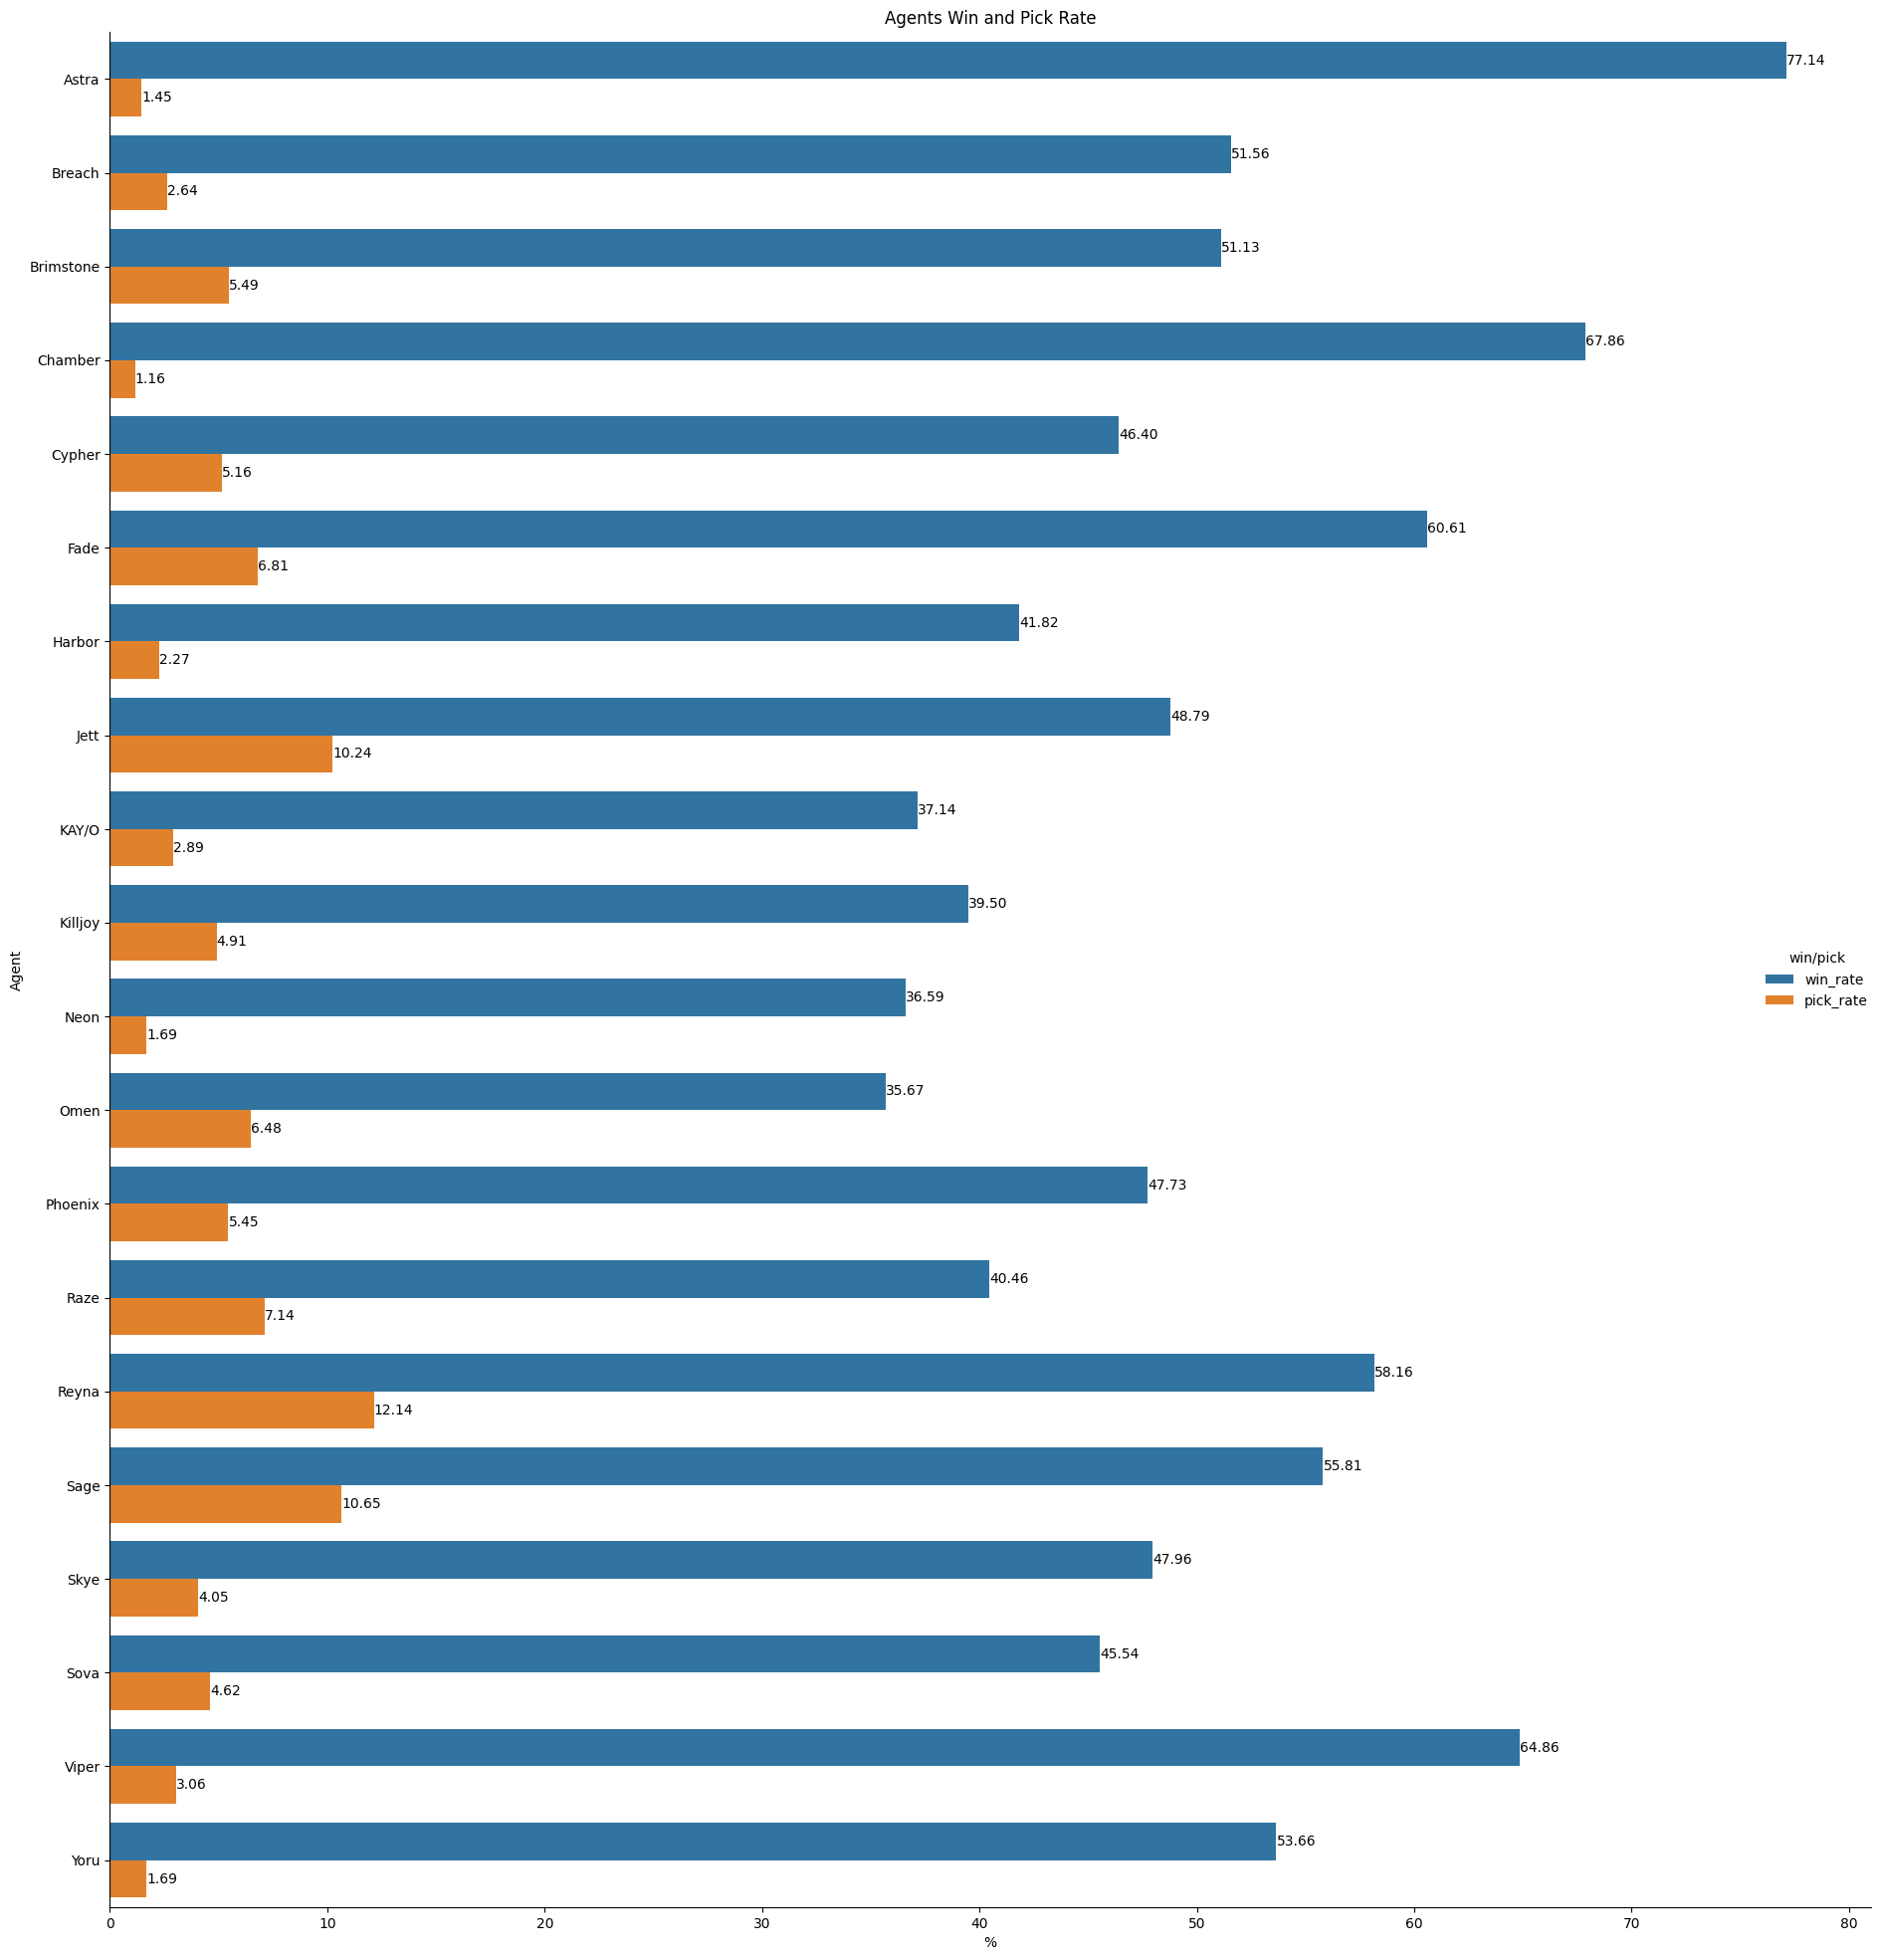

In [12]:
g = sns.catplot(y = "agent", x = "rates", hue = "win/pick", data = agent_data, kind = "bar")

g.fig.set_size_inches(10, 10)
g.fig.subplots_adjust(top=2, right=2)

ax = g.facet_axis(0, 0)

for container in ax.containers:
    rate = [f'{(values.get_width()):.2f}' for values in container]
    ax.bar_label(container, labels = rate, label_type = 'edge')

plt.xlabel("%")
plt.ylabel("Agent")
plt.title("Agents Win and Pick Rate")

plt.show()

In [24]:
import plotly.express as px

g = px.bar(agent_data, y = "agent", x = "rates", color = "win/pick", orientation = "h", barmode = "group")

g.show()